## PIP do Pennylane

In [1]:
%pip install pennylane

Note: you may need to restart the kernel to use updated packages.


## Código - Pré-processamento e clustering clássico

### Imports

In [1]:
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import RotosolveOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import rand_score, davies_bouldin_score, silhouette_score
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.model_selection import KFold

seed = 42

### normalize_data_transformY

In [2]:
def normalize_data_transformY(X,y,range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  y = 2*y -1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y, edgecolor="k")
    plt.show()
  return X_scaled, y

### cluster_classical

In [3]:
def cluster_classical(X,y, cluster_metric, unsupervised=True):
  # make a list of algorithms to use
  algorithms = [
      cluster.KMeans(2)
      , cluster.SpectralClustering(n_clusters=2,eigen_solver="arpack",affinity="nearest_neighbors")
      , cluster.AgglomerativeClustering(n_clusters=2)
      , cluster.DBSCAN()
  ]

  fig, axes = plt.subplots(1, len(algorithms)+1, figsize=(23, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

  # create a random cluster assignment for reference
  random_state = np.random.RandomState(seed=0)
  random_clusters = random_state.randint(low=0, high=2, size=len(X))

  # plot random assignment
  axes[0].scatter(X[:, 0], X[:, 1], c=random_clusters,
                  s=60)
  if unsupervised:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(X, random_clusters)))
  else:
    axes[0].set_title("Random assignment - {}: {:.2f}".format(cluster_metric.__name__,
            cluster_metric(y, random_clusters)))

  for ax, algorithm in zip(axes[1:], algorithms):
      # plot the cluster assignments and cluster centers
      clusters = algorithm.fit_predict(X)
      ax.scatter(X[:, 0], X[:, 1], c=clusters,
                s=60)
      if unsupervised:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                              cluster_metric(X, clusters)))
      else:
        ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__, cluster_metric.__name__,
                                            cluster_metric(y, clusters)))

### cluster_classical_kfold

In [4]:
def cluster_classical_kfold(X, y, k=2, unsupervised=True):
    # Lista de algoritmos de clustering
    algorithms = [
        cluster.KMeans(k),
        cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack", affinity="nearest_neighbors", n_neighbors=5),
        AgglomerativeClustering(n_clusters=k),
        #cluster.DBSCAN() ## Não utilizar, já que ele é quem seleciona o número de clusters
    ]

    # Configuração do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    # Lista para armazenar as métricas de cada algoritmo em cada fold
    rand_scores = {algo.__class__.__name__: [] for algo in algorithms}
    davies_bouldin_scores = {algo.__class__.__name__: [] for algo in algorithms}
    silhouette_scores = {algo.__class__.__name__: [] for algo in algorithms}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        if not unsupervised:
            y_train, y_val = y[train_index], y[val_index]
        
        # Aplicar cada algoritmo de clustering
        for algorithm in algorithms:
            algorithm.fit_predict(X_train)  # Treinamento com X_train

            # Prever clusters no conjunto de validação
            val_clusters = algorithm.fit_predict(X_val) if hasattr(algorithm, 'fit_predict') else algorithm.fit(X_val).predict(X_val)

            if not unsupervised:
                rand = rand_score(y_val, val_clusters)
            davies_bouldin = davies_bouldin_score(X_val, val_clusters)
            silhouette = silhouette_score(X_val, val_clusters)

            # score = cluster_metric(X_val, val_clusters) if unsupervised else cluster_metric(y_val, val_clusters)
            if not unsupervised:
                rand_scores[algorithm.__class__.__name__].append(rand)
            davies_bouldin_scores[algorithm.__class__.__name__].append(davies_bouldin)
            silhouette_scores[algorithm.__class__.__name__].append(silhouette)

    # Média das métricas por algoritmo após k-fold cross-validation
    if not unsupervised:
        avg_scores = {algo: np.mean(rand_scores[algo]) for algo in rand_scores}
        print("Rand:", avg_scores)

    avg_scores = {algo: np.mean(davies_bouldin_scores[algo]) for algo in davies_bouldin_scores}
    print("Davies Bouldin:", avg_scores)

    avg_scores = {algo: np.mean(silhouette_scores[algo]) for algo in silhouette_scores}
    print("Silhouette:", avg_scores)


### print_decision_region

In [5]:
def print_decision_region(X,y, qnode, x_max, y_max, weights, bias):
    y = np.array(y).reshape((len(y),1))

    plt.figure()
    cm = 'plasma'

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [variational_classifier(qnode,weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    # plot data
    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == 1],
        X[:, 1].reshape((len(X),1))[y == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )

    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == -1],
        X[:, 1].reshape((len(X),1))[y == -1],
        c="r",
        marker="o",
        edgecolors="k",
        label="class -1 train",
    )


    plt.legend()
    plt.show()

## Código de definições quânticas

In [111]:
dev = qml.device("lightning.gpu", wires=2)
def statepreparation(x):
    #qml.AmplitudeEmbedding(features=x, wires=range(2))
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def layer1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])


def layer2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

def layer3(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer4(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer5(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[6, 0], W[6, 1], W[6, 2], wires=0)
    qml.Rot(W[7, 0], W[7, 1], W[7, 2], wires=1)
    qml.CNOT(wires=[1, 0])


@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X, inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer1(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type2(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer2(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type3(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer3(W)

    return qml.expval(qml.PauliZ(wires=0))


@qml.qnode(dev, interface="autograd")
def circuit_type4(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer4(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type5(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer5(W)

    return qml.expval(qml.PauliZ(wires=0))

def variational_classifier(qnode,weights, bias, X,inputInLayer=False):
    return qnode(weights, X,inputInLayer) + bias

# def smooth_silhouette_loss(weights, bias, qnode, metric, features, labels, inputInLayer):

#     n_samples = features.shape[0]

#     # Calcula as previsões usando o classificador variacional
#     predictions = [variational_classifier(qnode,weights, bias, xi, inputInLayer) for xi in features]
    
#     predictions = np_qml.array(predictions)

#     # predictions = np_qml.sign(predictions)

#     predictions = 2 / (1 + np_qml.exp(-predictions)) - 1 

#     predictions_softmax = np.exp(predictions) / np.sum(np.exp(predictions), keepdims=True)
#     entropy = -np.sum(predictions_softmax * np.log(predictions_softmax + 1e-10))

#     # Verifica a entropia média das previsões (isso pode ser usado como uma métrica de diversidade)
#     if np.mean(entropy) < 0.1:  # Se a entropia for muito baixa, significa que as previsões são muito próximas
#         return 2.0  # Perda alta (má performance)


#     # # Verifica se há pelo menos dois clusters distintos
#     # if len(np_qml.unique(predictions)) < 2:
#     #     return 2.0  # Perda alta (má performance)

#     # Calcula todas as distâncias pairwise
#     distances = np.linalg.norm(features[:, None] - features[None, :], axis=2)  # (n_samples, n_samples)

#     silhouette_scores = []

#     for i in range(n_samples):
#         # Máscaras para clusters
#         same_cluster = predictions == predictions[i]
#         other_cluster = predictions != predictions[i]

#         # a(i): Distância média para o mesmo cluster
#         a_i = np.mean(distances[i, same_cluster]) if np.sum(same_cluster) > 1 else 0.0

#         # b(i): Distância média para o cluster mais próximo (diferente)
#         other_cluster_distances = distances[i, other_cluster]  # Distâncias para os exemplos do outro cluster
#         if len(other_cluster_distances) > 0:
#             b_i = np.mean(other_cluster_distances)  # Usamos a média das distâncias
#         else:
#             b_i = 0.0  # Caso em que não existam outros clusters

#         # Suavização do denominador (max suave usando log-sum-exp)
#         smooth_max = np.log(np.exp(a_i) + np.exp(b_i))

#         # Silhouette score suavizado
#         s_i = (b_i - a_i) / smooth_max
#         silhouette_scores.append(s_i)

#     # Retorna a perda como 1 - média dos coeficientes silhouette
#     loss = 1 - np.mean(silhouette_scores)
#     return loss

def threshold(x):
    return 1 if x >= 0 else -1

def metric_square_loss_silhouette(features, predictions, labels):
#   predictions = np_qml.sign(predictions)
  if len(np.unique(predictions)) < 2:
        return 2

  score = silhouette_score(features, predictions)
  return np_qml.float16(1 - np_qml.float16(score))

def metric_square_loss_rand_score(features, predictions, labels):
    # predictions = np_qml.sign(predictions)
    # predictions = 2 / (1 + np_qml.exp(-np_qml.array(predictions))) - 1
    # predictions = np.array(list(map(threshold, predictions)))
    rand = rand_score(labels, predictions)
    return np_qml.float16(1-rand)

def metric_square_loss_davies_bouldin_score(features, predictions, labels):
    # predictions = np_qml.sign(predictions)
    # predictions = 2 / (1 + np_qml.exp(-np_qml.array(predictions))) - 1
    # predictions = np.array(list(map(threshold, predictions)))
    if len(np.unique(predictions)) < 2:
        return 100
    return np_qml.float16(1 - np_qml.float16(davies_bouldin_score(features, predictions)))

def square_loss(metric, features, predictions, labels):
    # predictions = [float(i) for i in predictions]
    predictions = 2 / (1 + np_qml.exp(-np_qml.array(predictions))) - 1
    predictions = np.array(list(map(threshold, predictions)))
    if len(np.unique(predictions))==1:
        return np_qml.float16(1)
    else:
        metrinc_score = metric(features, predictions, labels)
        return metrinc_score

def cost(weights,bias, qnode,metric,features, labels,inputInLayer):
    predictions = [variational_classifier(qnode,weights, bias, xi, inputInLayer) for xi in features]
    predictions = np_qml.array(predictions)
    # predictions = np_qml.sign(predictions)
    return square_loss(metric, features, predictions, labels) + 0.01 * np_qml.sum(bias**2) 

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

## Código do treinamento

### train

In [26]:
def train(qnode,X,y,num_qubits,num_params_w_lines, num_params_w_columns,metric,metricValidation,num_layers,weight_init_max,optimizer, dic_optimizer, seed,inputInLayer=False,iterations=100):
    np_qml.random.seed(seed)

    #num_qubits = 2
    #num_layers = 2
    #num_train=len(X)

    weights_init = (weight_init_max) * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)
    bias_init = np_qml.array(0.0, requires_grad=True)

    batch_size = len(X)

    drawer = qml.draw(circuit)
    print(drawer(weights_init, X))

    #num_steps_spsa = 10
    #opt = qml.SPSAOptimizer(maxiter=num_steps_spsa)
    opt = optimizer(**dic_optimizer)

    # train the variational classifier
    weights = weights_init
    bias = bias_init

    best_weights = weights
    best_bias = bias
    best_cost = 99999

    for it in range(iterations):

        # Update the weights by one optimizer step
        batch_index = np_qml.random.randint(0, batch_size, (batch_size,))
        X_train_batch = X[batch_index]
        Y_train_batch = y[batch_index]

        #TREINANDO
        arguments = [weights, bias, qnode,metric,X_train_batch, Y_train_batch,inputInLayer]
        weights, bias, _, _,_,_,_ = opt.step(cost, *arguments)

        # Compute predictions on train and validation set
        predictions_val = [np_qml.sign(variational_classifier(qnode,weights, bias, xi)) for xi in X]

        # Compute accuracy on train and validation set
        acc_val = metricValidation(X,predictions_val,y)

        iteration_cost = cost(weights, bias, qnode,metric,X, y,inputInLayer)
        if iteration_cost < best_cost:
          best_weights, best_bias, best_cost = weights, bias, iteration_cost

        print(
            "Iter: {:5d} | Cost ({}): {:0.7f} | Acc validation ({}): {:0.7f} "
            "".format(it + 1, metric.__name__,iteration_cost, metricValidation.__name__,acc_val)
        )
        #print("W",weights,"B",bias)
    return best_weights, best_bias

### tain_kfold

In [ ]:
def train_kfold(
        qnode, 
        X, 
        y, 
        num_qubits, 
        num_params_w_lines, 
        num_params_w_columns, 
        metric, 
        # metricValidation, 
        num_layers, 
        weight_init_max, 
        optimizer, 
        dic_optimizer, 
        seed, 
        inputInLayer=False, 
        iterations=100, 
        k=10,
        log_interval=20,
        batch_size=32
    ):
    np_qml.random.seed(seed)

    # Inicialização do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    
    fold_scores_rand = []
    fold_scores_davies = []
    fold_scores_silhouette = []
    
    # Loop pelos folds do k-fold
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        print(f"Treinando Fold {fold_idx + 1}/{k}")

        # Inicialização do otimizador
        opt = optimizer(**dic_optimizer)
        
        if isinstance(opt, qml.RotosolveOptimizer):
            # Configuração específica para RotosolveOptimizer
            weights_init = np.random.uniform(-weight_init_max, weight_init_max, (num_layers, num_params_w_lines, num_params_w_columns), requires_grad=True)
            bias_init = np.random.uniform(-weight_init_max, weight_init_max, size=(num_layers,), requires_grad=True)  # Ajustando para um vetor de tamanho num_layers

            # Transformando para arrays quânticos com gradientes
            weights_init = np_qml.array(weights_init, requires_grad=True)
            bias_init = np_qml.array(bias_init, requires_grad=True)
        else:
            # Configuração padrão para os outros otimizadores
            weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)

            bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        best_weights = weights
        best_bias = bias
        best_cost = float('inf')

        # Treinamento para o número de iterações desejado
        for it in range(iterations):
            
            # Mini-batch aleatório
            batch_index = np_qml.random.randint(0, len(X_train), batch_size)
            X_train_batch = X_train[batch_index]
            Y_train_batch = y_train[batch_index]

            # Treinamento do modelo no batch
            arguments = [weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer]

            weights, bias, _, _, _, _, _ = opt.step(cost, *arguments)

            if log_interval > 0 and (it % log_interval == 0 or it == iterations-1):
                print(weights, bias)
                iteration_cost = cost(weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer)
                if iteration_cost < best_cost:
                    best_weights, best_bias, best_cost = weights, bias, iteration_cost

                print(
                    "Iter: {:5d} | Cost ({}): {:0.7f} | Best Cost: {:0.7f}"
                    .format(it + 1, metric.__name__, iteration_cost, best_cost)
                )

                print_decision_region(X, y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)
        
        # Predição e cálculo da métrica de validação
        predictions_val = [np_qml.sign(variational_classifier(qnode, weights, bias, xi)) for xi in X_val]

        acc_val_rand = metric_square_loss_rand_score(X_val, predictions_val, y_val)
        acc_val_davies = metric_square_loss_davies_bouldin_score(X_val, predictions_val, y_val)
        acc_val_silhouette = metric_square_loss_silhouette(X_val, predictions_val, y_val)

        # Armazenar a acurácia de validação do fold atual
        fold_scores_rand.append(acc_val_rand)
        fold_scores_davies.append(acc_val_davies)
        fold_scores_silhouette.append(acc_val_silhouette)

    # Resultado final: média das acurácias nos folds
    avg_score_rand = np.mean(fold_scores_rand)
    print(f"Rand (Médio): {avg_score_rand:.4f}")

    avg_score_davies = np.mean(fold_scores_davies)
    print(f"Davies (Médio): {avg_score_davies:.4f}")

    avg_score_silhouette = np.mean(fold_scores_silhouette)
    print(f"Silhouette (Média): {avg_score_silhouette:.4f}")

    return best_weights, best_bias, avg_score_rand, avg_score_davies, avg_score_silhouette


## Base de dados - 2 bolhas / 2 classes

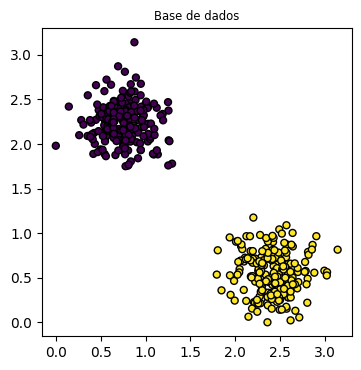

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Rand: {'KMeans': 1.0, 'SpectralClustering': 1.0, 'AgglomerativeClustering': 1.0}
Davies Bouldin: {'KMeans': 0.24493767091940533, 'SpectralClustering': 0.24493767091940533, 'AgglomerativeClustering': 0.24493767091940533}
Silhouette: {'KMeans': 0.8253424401644138, 'SpectralClustering': 0.8253424401644138, 'AgglomerativeClustering': 0.8253424401644138}
Davies Bouldin: {'KMeans': 0.24493767091940533, 'SpectralClustering': 0.24493767091940533, 'AgglomerativeClustering': 0.24493767091940533}
Silhouette: {'KMeans': 0.8253424401644138, 'SpectralClustering': 0.8253424401644138, 'AgglomerativeClustering': 0.8253424401644138}


In [8]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,unsupervised=False)
cluster_classical_kfold(X,y,unsupervised=True)

In [121]:
# Definindo as combinações de otimizadores e circuitos a serem testados
optimizers = {
    'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
    # 'RotosolveOptimizer': RotosolveOptimizer,
    # 'GradientDescentOptimizer': GradientDescentOptimizer,
    # 'SPSAOptimizer': qml.SPSAOptimizer
}

circuits = [
    (circuit_type1, 2), 
    # (circuit_type2, 4), 
    # (circuit_type3, 6), 
    # (circuit_type4, 6), 
    # (circuit_type5, 8)
]

# Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.01, 'momentum': 0.7},
    'RotosolveOptimizer': {},
    'GradientDescentOptimizer': {'stepsize': 1},
    'SPSAOptimizer': {'maxiter': 10}
}

# Parâmetros do experimento
num_layers_options = [
    2, 
    # 4
]  # Escolher o número de camadas para o experimento

# Armazenamento dos melhores resultados
best_results = {
    'optimizer': None,
    'circuit_type': None,
    'num_layers': None,
    'avg_score_rand': float('inf'),
    'avg_score_davies': float('inf'),
    'avg_score_silhouette': float('inf'),
    'weights': None,
    'bias': None,
    'qnode': None
}

log_results = []

# Loop para experimentar combinações
for circuit_fn, num_params_w_lines in circuits:
    for optimizer_name, optimizer_class in optimizers.items():
        for num_layers in num_layers_options:
            print(f"{circuit_fn} - {optimizer_name} - {num_layers}")
            # Instanciar o circuito e o QNode
            circuit = circuit_fn
            qnode = qml.QNode(circuit, dev, interface="torch")

            # Treinamento com k-fold
            weights, bias, avg_score_rand, avg_score_davies, avg_score_silhouette = train_kfold(
                qnode,
                X,
                y,
                num_qubits=2,
                num_params_w_lines=num_params_w_lines,
                num_params_w_columns=3,
                # metric=metric_square_loss_rand_score,
                # metric=metric_square_loss_davies_bouldin_score,
                metric=metric_square_loss_silhouette,
                # metricValidation=metric_square_loss_rand_score,
                num_layers=num_layers,
                weight_init_max=np.pi,
                optimizer=optimizer_class,
                dic_optimizer=optimizer_params[optimizer_name],
                seed=seed,
                inputInLayer=False,
                iterations=100,
                k=10,
                log_interval=10,
                batch_size=50
            )

            # Adicionar os resultados ao log
            log_results.append({
                'circuit_fn': circuit_fn.__name__,
                'optimizer': optimizer_name,
                'num_layers': num_layers,
                'avg_score_rand': avg_score_rand,
                'avg_score_davies': avg_score_davies,
                'avg_score_silhouette': avg_score_silhouette,
                'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                'bias': bias.tolist(),  # Convertendo para lista, caso seja um array
            })

            # Armazenar os melhores resultados
            if avg_score_rand < best_results['avg_score_rand']:
                best_results.update({
                    'optimizer': optimizer_name,
                    'circuit_type': circuit_fn.__name__,
                    'num_layers': num_layers,
                    'avg_score_rand': avg_score_rand,
                    'avg_score_davies': avg_score_davies,
                    'avg_score_silhouette': avg_score_silhouette,
                    'weights': weights,
                    'bias': bias,
                    'qnode': qnode
                })

# Exibir os melhores parâmetros e resultados
print("Melhores Resultados:")
print(f"Otimizer: {best_results['optimizer']}")
print(f"Circuit Type: {best_results['circuit_type']}")
print(f"Num Layers: {best_results['num_layers']}")
print(f"Avg Score Rand: {best_results['avg_score_rand']}")
print(f"Avg Score Davies: {best_results['avg_score_davies']}")
print(f"Avg Score Silhouette: {best_results['avg_score_silhouette']}")

# Salvar o log em uma planilha CSV
log_df = pd.DataFrame(log_results)

# Ou salvar em Excel (se preferir)
log_df.to_excel('experiment_log.xlsx', index=False)

# Visualizar a decisão do melhor modelo
print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])


<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 2
Treinando Fold 1/10
7
[tensor([[[ 1.56047353, -0.43437011,  2.03477355],
         [ 4.78473941, -0.73561452, -0.73556294]],

        [[ 4.96124338,  2.41096731, -1.47489728],
         [ 1.70450265, -1.45586962, -1.46313317]]], requires_grad=True), tensor(0., requires_grad=True), <QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'>, <function metric_square_loss_silhouette at 0x7f9fadc21510>, array([[0.97767961, 2.08700393],
       [0.68246647, 2.40504287],
       [2.2892044 , 0.57707919],
       [2.40805487, 0.25971802],
       [2.79506596, 0.42632356],
       [2.67033682, 0.12931839],
       [2.51304778, 0.54024779],
       [2.50897369, 0.32426903],
       [0.69427142, 2.87195703],
       [2.34353824, 0.45960055],
       [0.88915639, 2.49470135],
       [1.03109589, 2.11265136],
       [2.7852617 , 0.57557094],
       [0.49795649, 1.93956291],

IndexError: index 2 is out of bounds for axis 1 with size 2

### Treinando

In [38]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias, avg_score = train_kfold(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1245117 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1030273 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 4/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1015625 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 5/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 6/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1044922 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 7/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2026367 | Acc validation (metric_square_loss_rand_score): 0.0499878
Treina

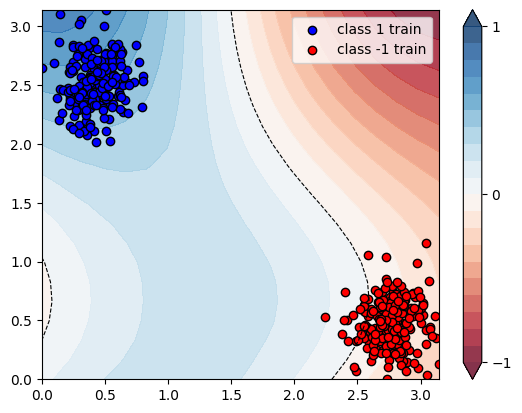

In [39]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

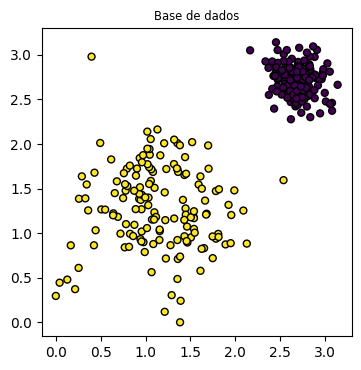

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


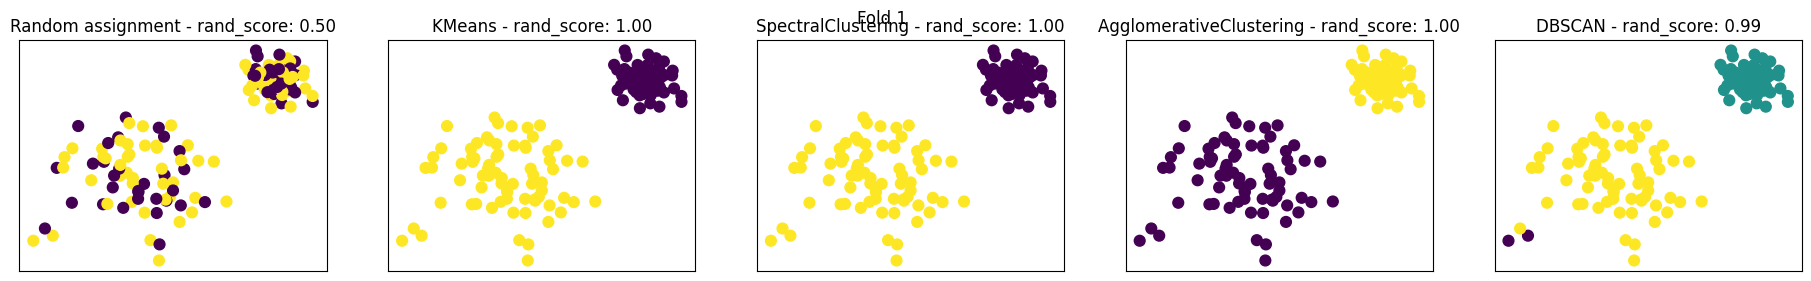

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


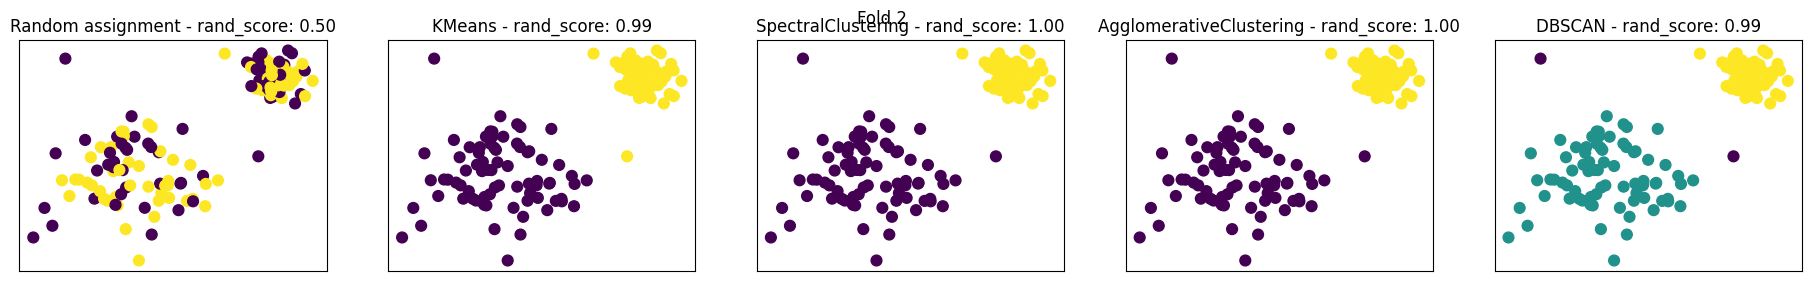

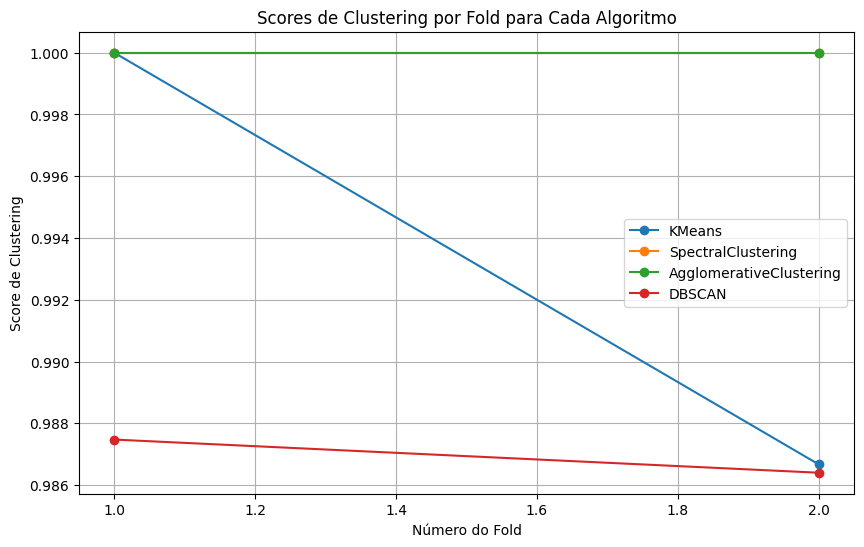

Médias das métricas após k-fold cross-validation: {'KMeans': 0.9933333333333334, 'SpectralClustering': 1.0, 'AgglomerativeClustering': 1.0, 'DBSCAN': 0.9869351230425056}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


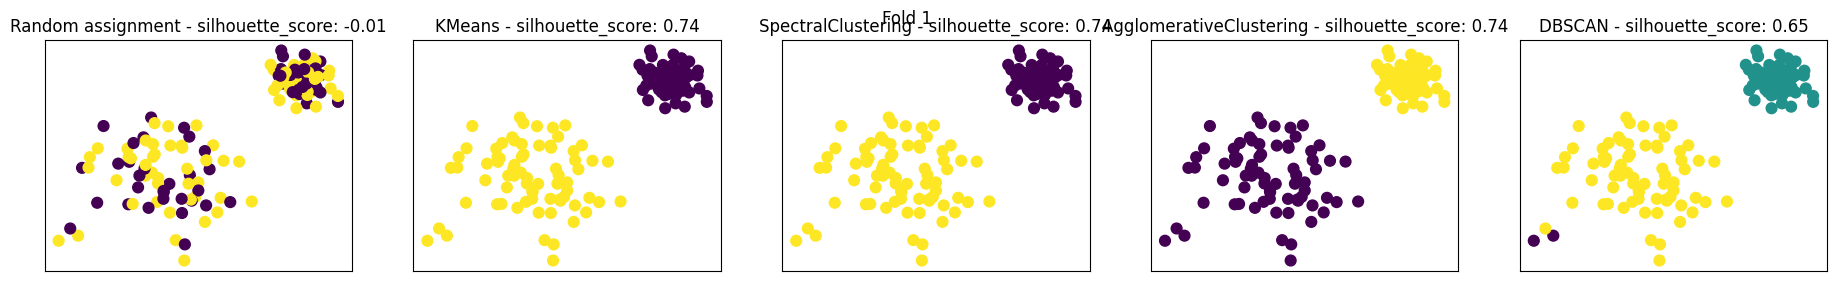

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


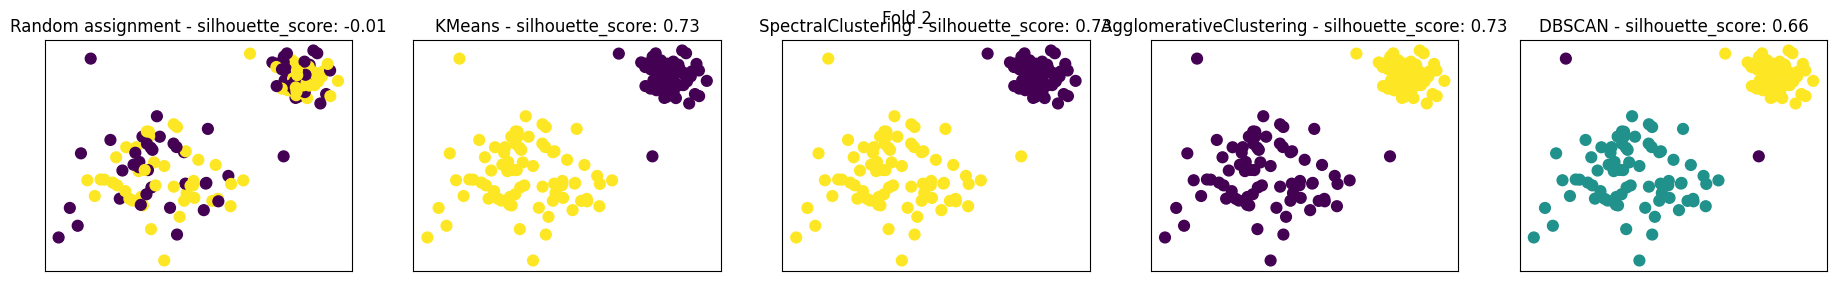

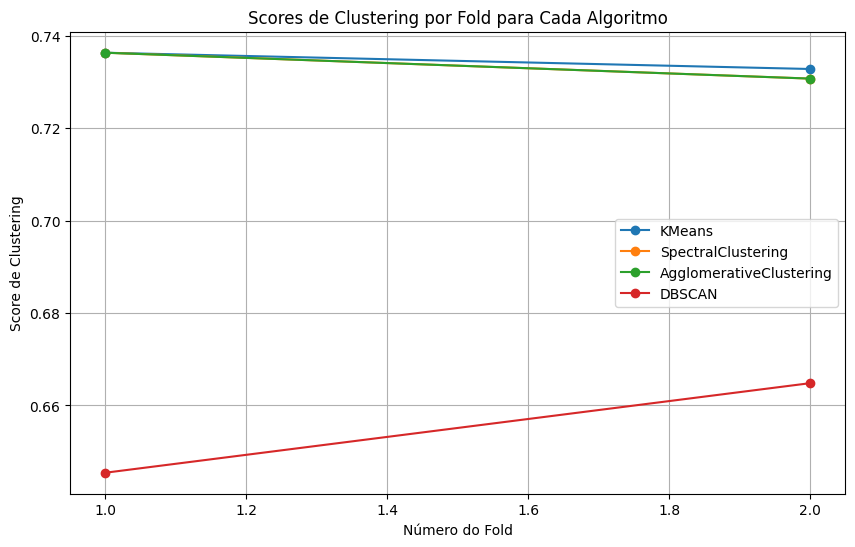

Médias das métricas após k-fold cross-validation: {'KMeans': 0.7345921612706987, 'SpectralClustering': 0.7335523556910223, 'AgglomerativeClustering': 0.7335523556910223, 'DBSCAN': 0.6551381992967206}


In [90]:
# blobs with varied variances
X, y = make_blobs(
    n_samples=300, centers=2, cluster_std=[1.0, 2.5], random_state=1
)

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)



# rng = np.random.RandomState(1)
# no_structure = rng.rand(300, 2), None


# noisy_circles = make_circles(
#     n_samples=(200, 200), factor=0.5, noise=0.05, random_state=42
# )

cluster_classical_kfold(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical_kfold(X,y,cluster_metric=silhouette_score, unsupervised=True)

<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/2
Gradiente do bias: 0.0
Weights: [[[ 5.10303146 -1.92188945 -1.6593005 ]
  [-3.37083034  2.71875825 -7.23049706]]

 [[ 5.48148782 -2.39140201  1.00229088]
  [-0.78342014  4.59334755 -6.47212292]]]
Bias: 0.0
Iter:     1 | Cost (metric_square_loss_silhouette): 0.8125000 | Acc validation (metric_square_loss_rand_score): 0.3808594
Gradiente do bias: 0.0
Weights: [[[ 5.10303146 -1.92188945 -1.6593005 ]
  [-3.37083034  2.71875825 -7.23049706]]

 [[ 5.48148782 -2.39140201  1.00229088]
  [-0.78342014  4.59334755 -6.47212292]]]
Bias: 0.0
Iter:     2 | Cost (metric_square_loss_silhouette): 0.8125000 | Acc validation (metric_square_loss_rand_score): 0.3808594
Gradiente do bias: 0.0
Weights: [[[ 5.10303146 -1.92188945 -1.6593005 ]
  [-3.37083034  2.71875825 -7.23049706]]

 [[ 5.48148782 -2.39140201  1.00229088]
  [-0.78342014  4.59334755 -6.47212292]]]
Bias: 0.0
Iter:

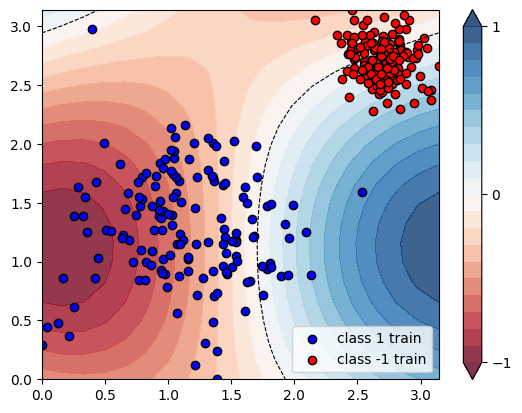

In [97]:
# Definindo as combinações de otimizadores e circuitos a serem testados
optimizers = {
    # 'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
    # 'RotosolveOptimizer': RotosolveOptimizer,
    'GradientDescentOptimizer': GradientDescentOptimizer,
    # 'SPSAOptimizer': qml.SPSAOptimizer
}

circuits = [
    (circuit_type1, 2),
    # (circuit_type2, 4),
    # (circuit_type3, 6),
    # (circuit_type4, 6), 
    # (circuit_type5, 8)
]

# Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
    'RotosolveOptimizer': {},
    'GradientDescentOptimizer': {'stepsize': 0.1},
    'SPSAOptimizer': {'maxiter': 10}
}

# Parâmetros do experimento
num_layers_options = [
    2, 
    # 4
]  # Escolher o número de camadas para o experimento

# Armazenamento dos melhores resultados
best_results = {
    'optimizer': None,
    'circuit_type': None,
    'num_layers': None,
    'avg_score': float('inf'),
    'weights': None,
    'bias': None
}

# Loop para experimentar combinações
for circuit_fn, num_params_w_lines in circuits:
    for optimizer_name, optimizer_class in optimizers.items():
        for num_layers in num_layers_options:
            print(f"{circuit_fn} - {optimizer_name} - {num_layers}")
            # Instanciar o circuito e o QNode
            circuit = circuit_fn
            qnode = qml.QNode(circuit, dev, interface="torch")

            # # Inicializar o otimizador com seus parâmetros
            # optimizer = optimizer_class(**optimizer_params.get(optimizer_name, {}))

            # Treinamento com k-fold
            weights, bias, avg_score = train_kfold(
                qnode,
                X,
                y,
                num_qubits=3,
                num_params_w_lines=num_params_w_lines,
                num_params_w_columns=3,
                metric=metric_square_loss_silhouette,
                metricValidation=metric_square_loss_rand_score,
                num_layers=num_layers,
                weight_init_max=np.pi,
                optimizer=optimizer_class,
                dic_optimizer=optimizer_params[optimizer_name],
                seed=1,
                inputInLayer=False,
                iterations=10,
                k=2
            )

            # Armazenar os melhores resultados
            if avg_score < best_results['avg_score']:
                best_results.update({
                    'optimizer': optimizer_name,
                    'circuit_type': circuit_fn.__name__,
                    'num_layers': num_layers,
                    'avg_score': avg_score,
                    'weights': weights,
                    'bias': bias,
                    'qnode': qnode
                })

# Exibir os melhores parâmetros e resultados
print("Melhores Resultados:")
print(f"Otimizer: {best_results['optimizer']}")
print(f"Circuit Type: {best_results['circuit_type']}")
print(f"Num Layers: {best_results['num_layers']}")
print(f"Avg Score: {best_results['avg_score']}")

# Visualizar a decisão do melhor modelo
print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])

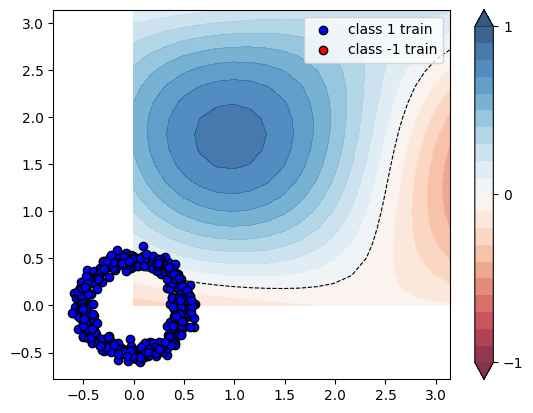

In [15]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [41]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias, avg_score = train_kfold(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6933594 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1093750 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0000000 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 4/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6699219 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 5/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4833984 | Acc validation (metric_square_loss_rand_score): 0.4665527
Treinando Fold 6/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.1230469 | Acc validation (metric_square_loss_rand_score): 0.3281250
Treinando Fold 7/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2700195 | Acc validation (metric_square_loss_rand_score): 0.1423340
Treina

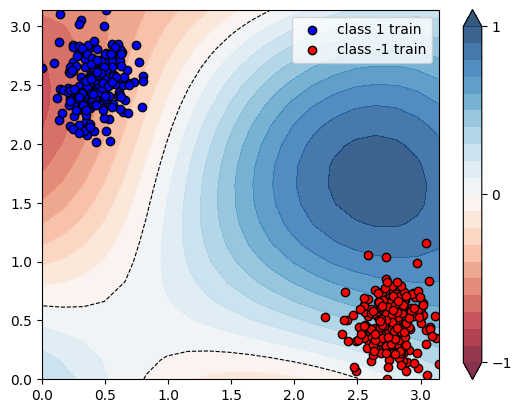

In [42]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

## Base de dados - 4 bolhas / 2 classes

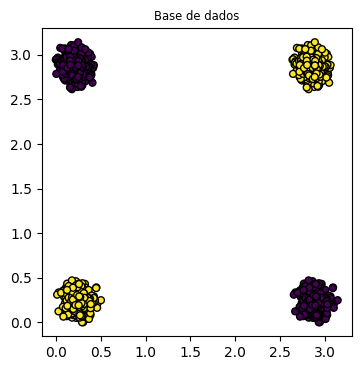

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


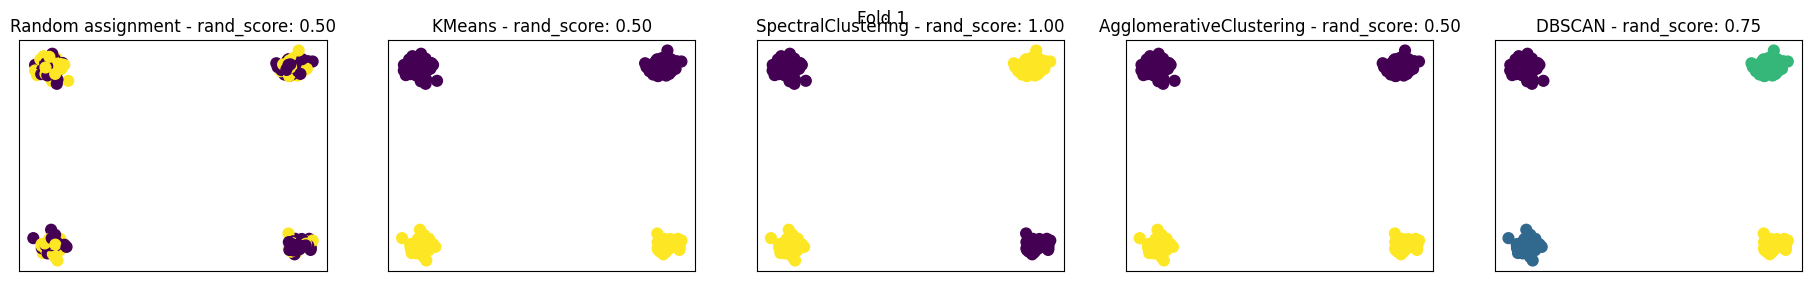

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


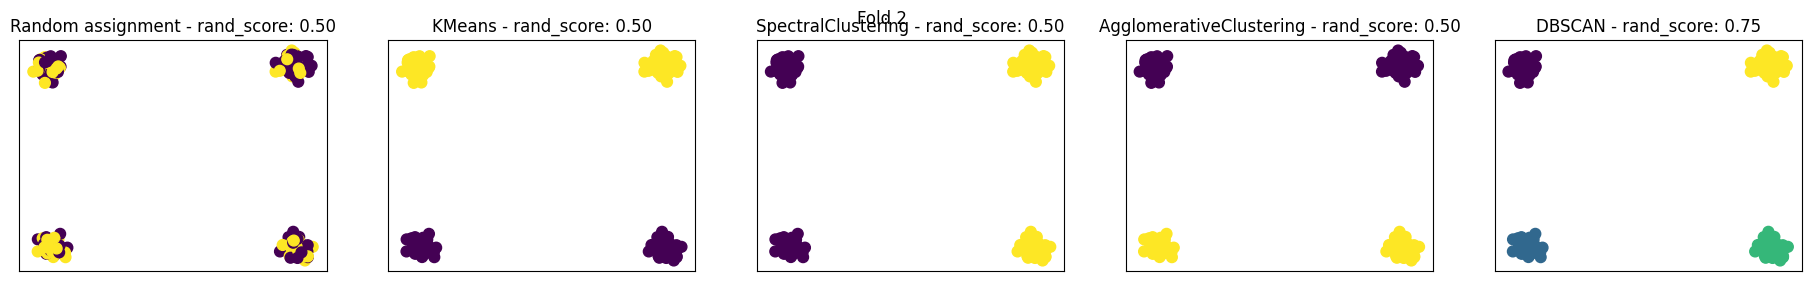

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


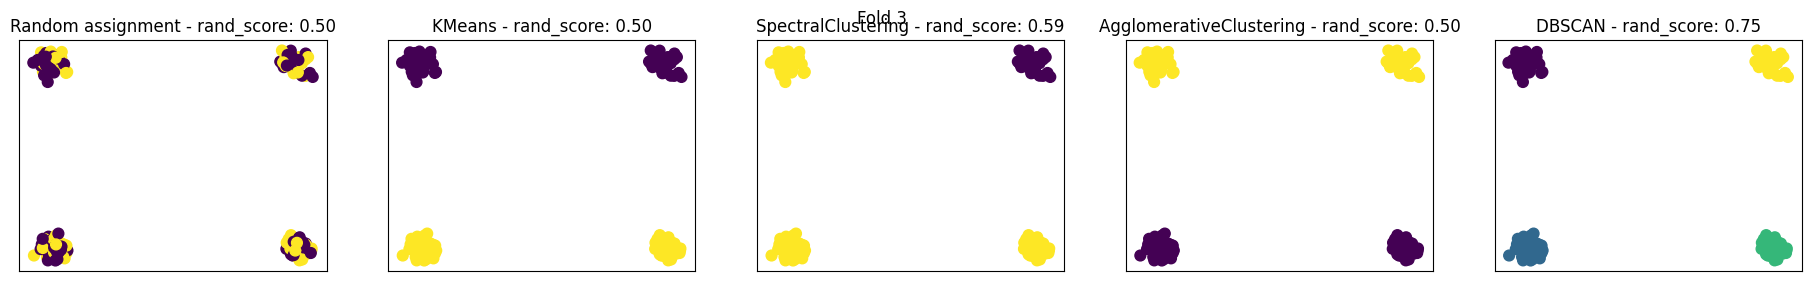

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


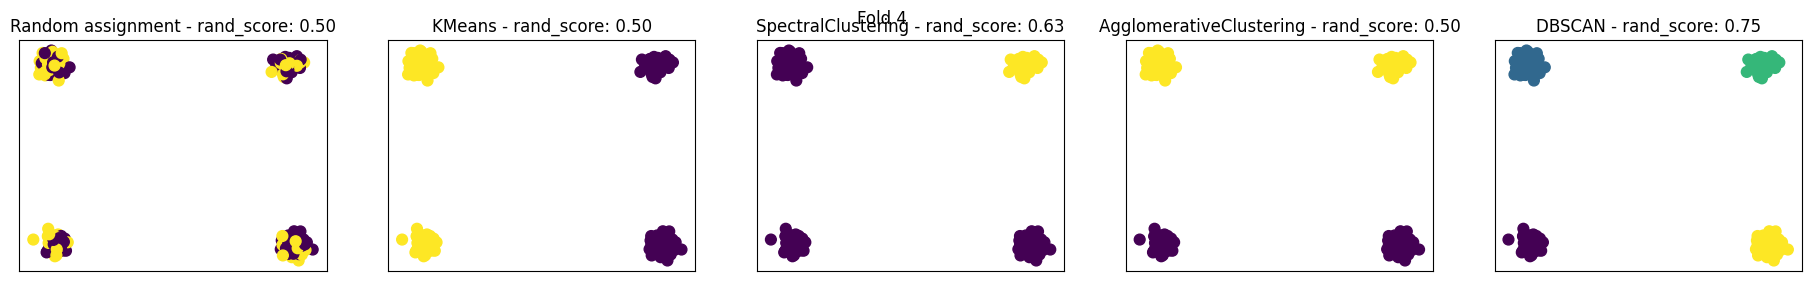

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


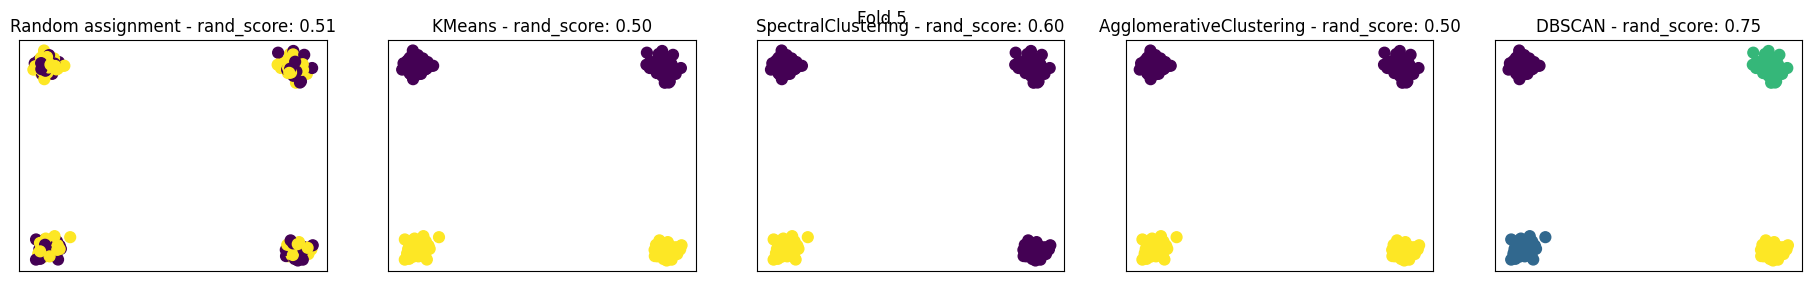

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


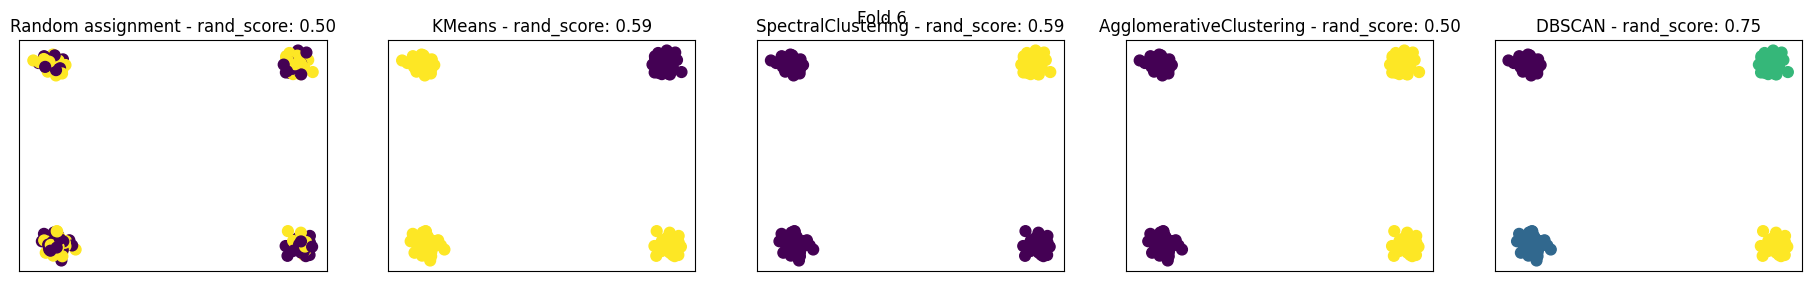

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


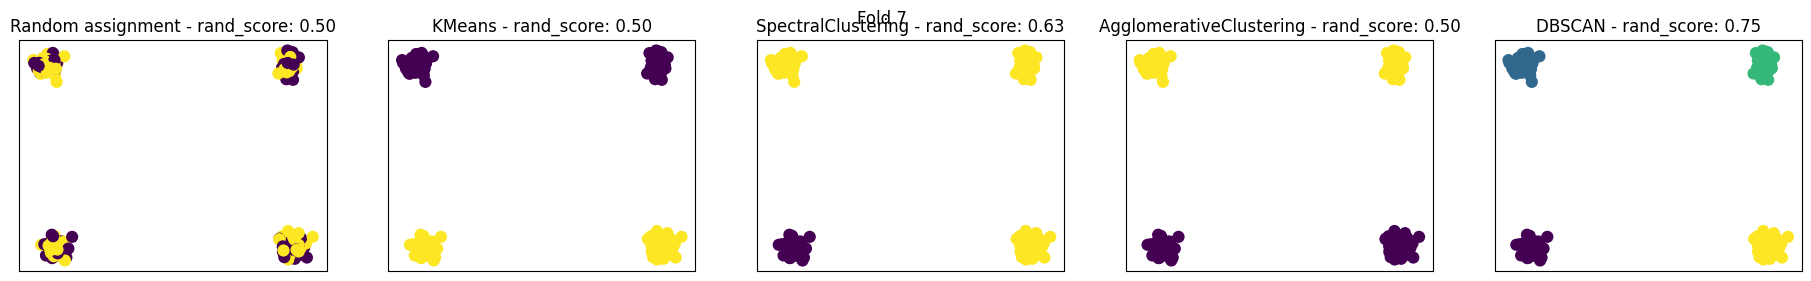

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


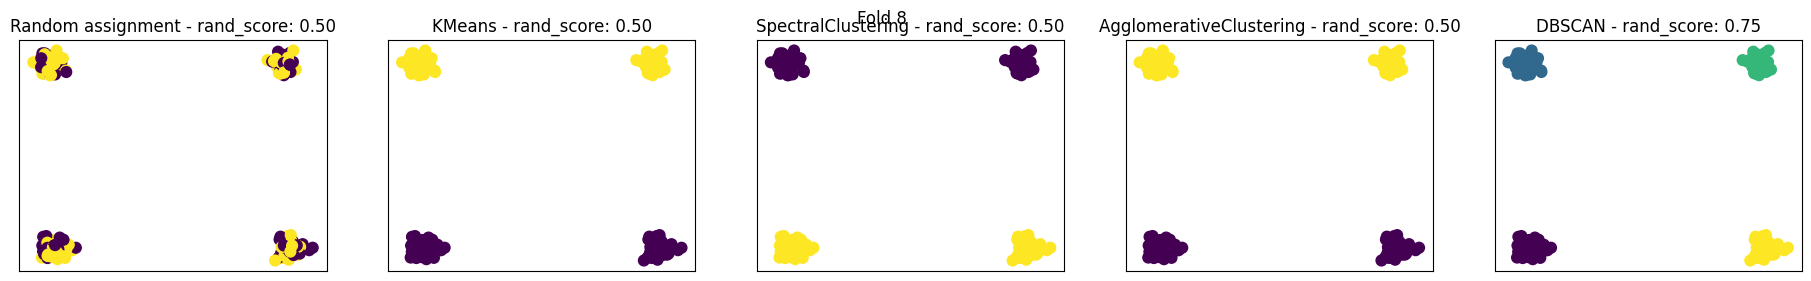

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


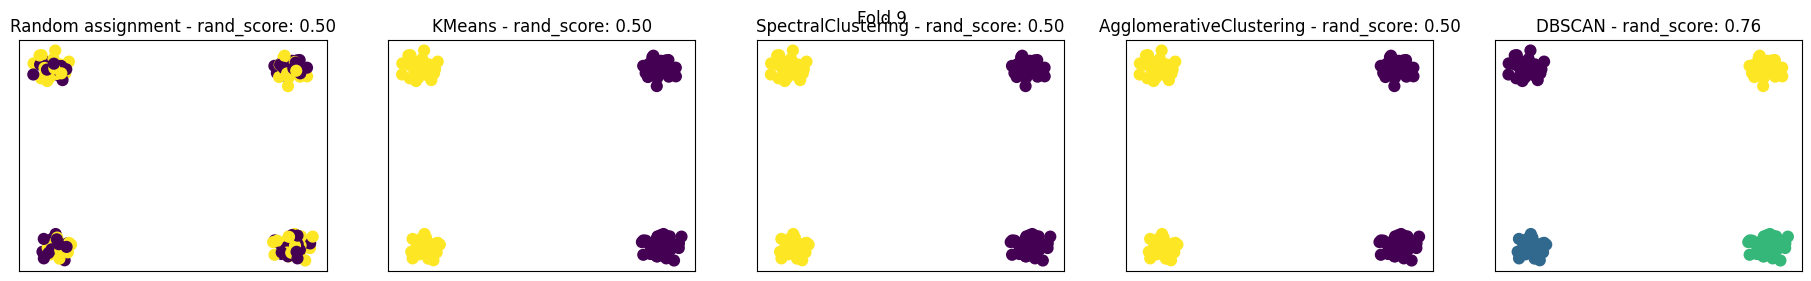

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


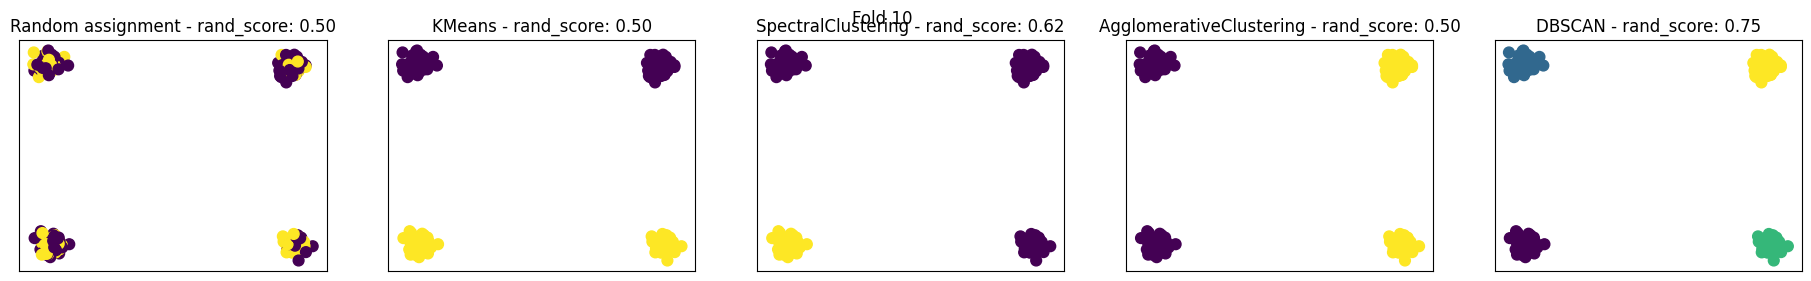

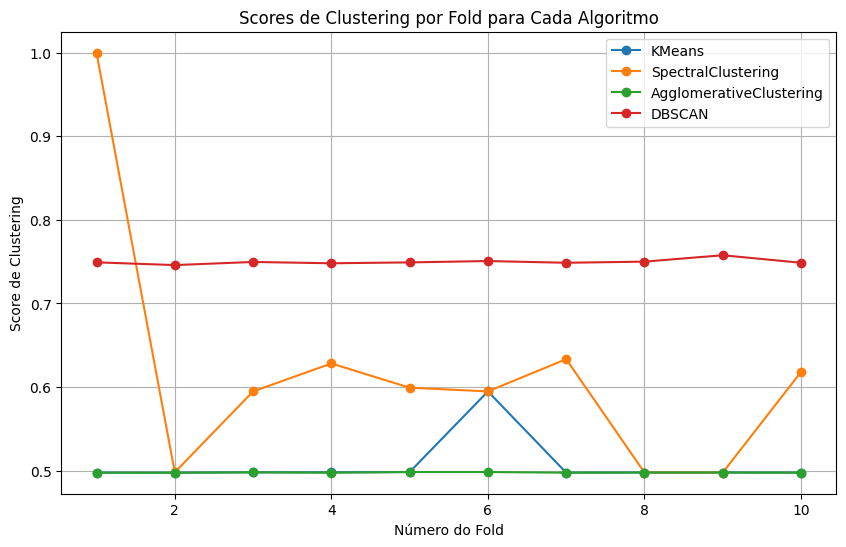

Médias das métricas após k-fold cross-validation: {'KMeans': 0.5074422110552763, 'SpectralClustering': 0.616180904522613, 'AgglomerativeClustering': 0.4977537688442212, 'DBSCAN': 0.749788944723618}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


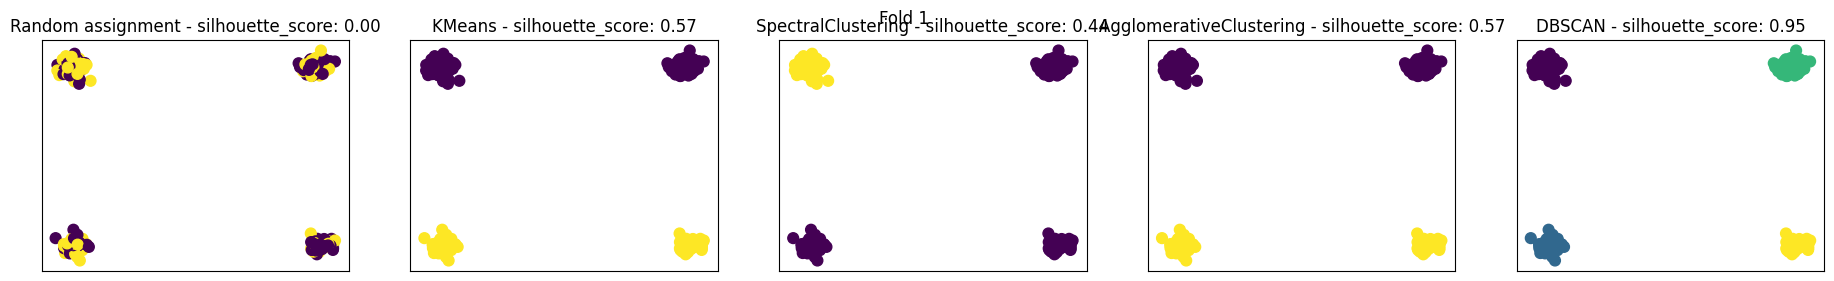

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


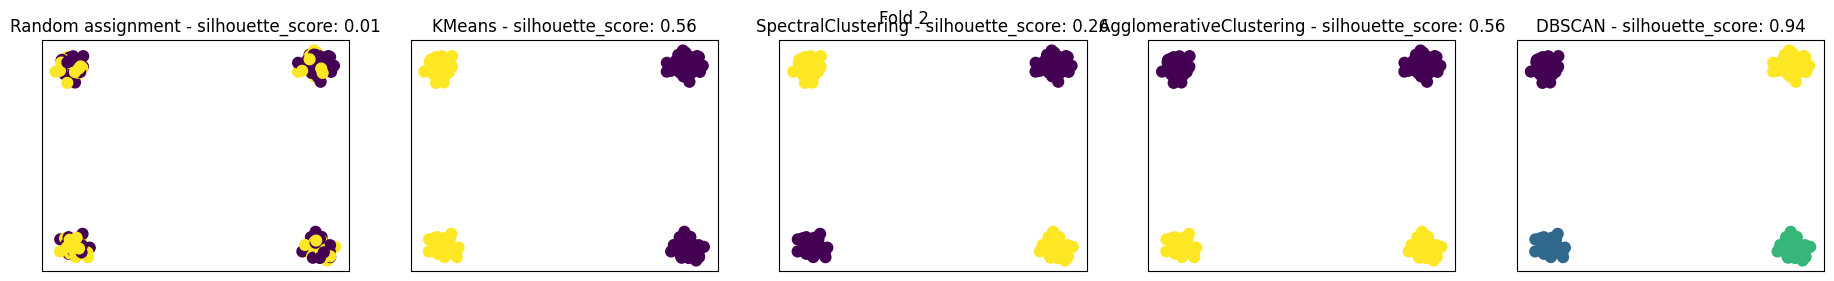

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


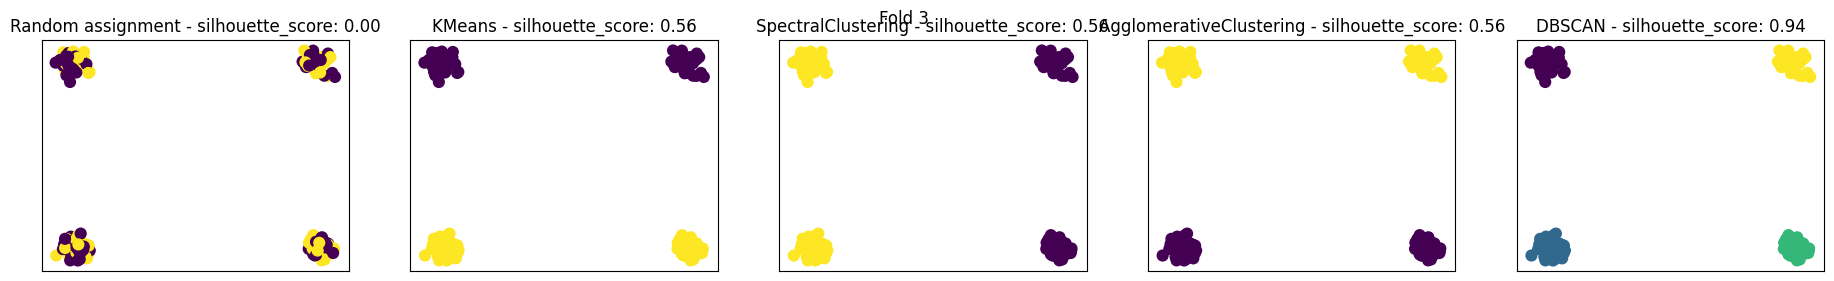

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


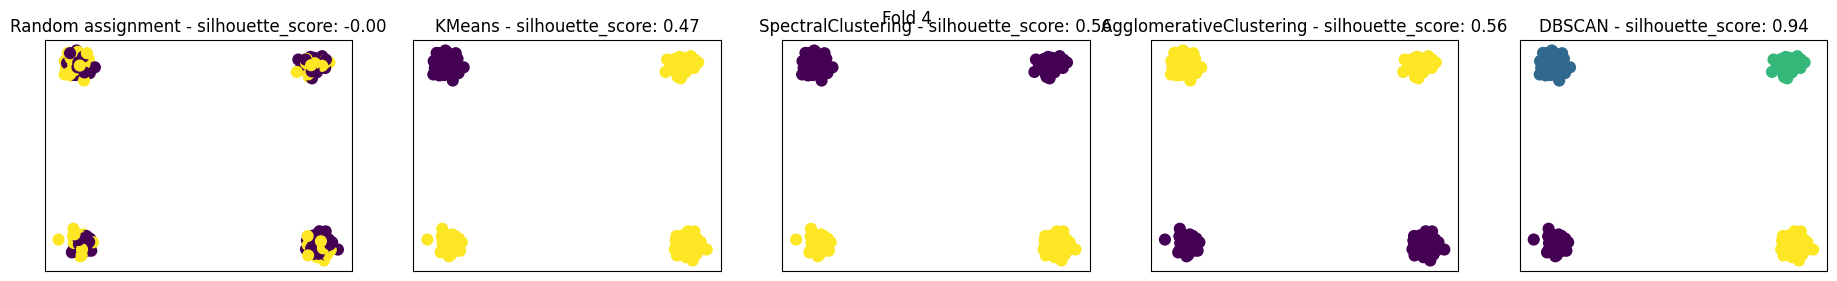

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


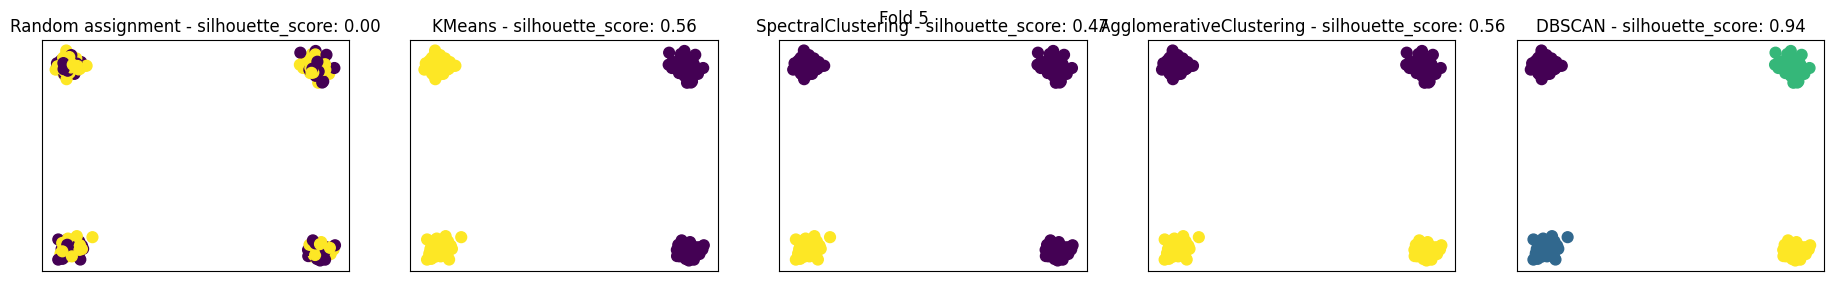

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


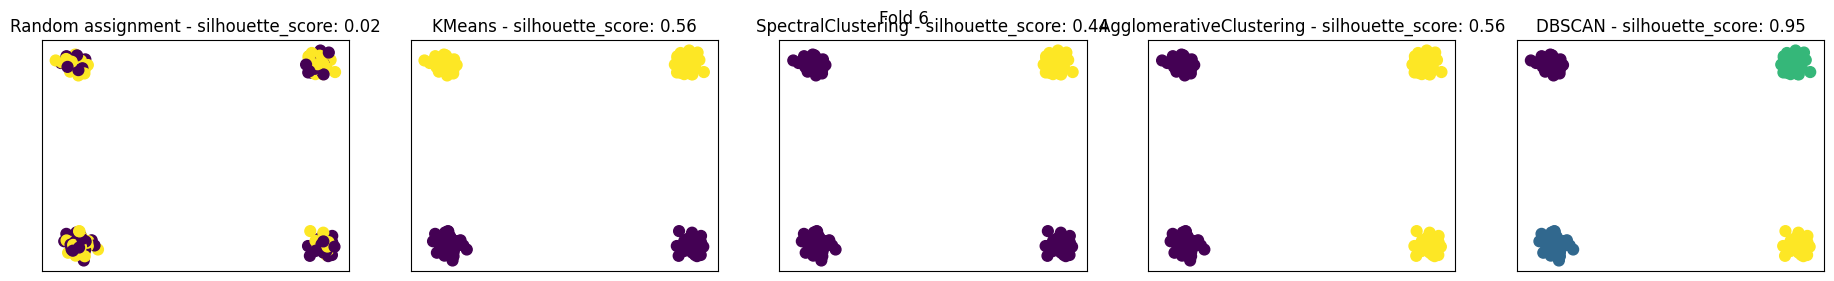

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


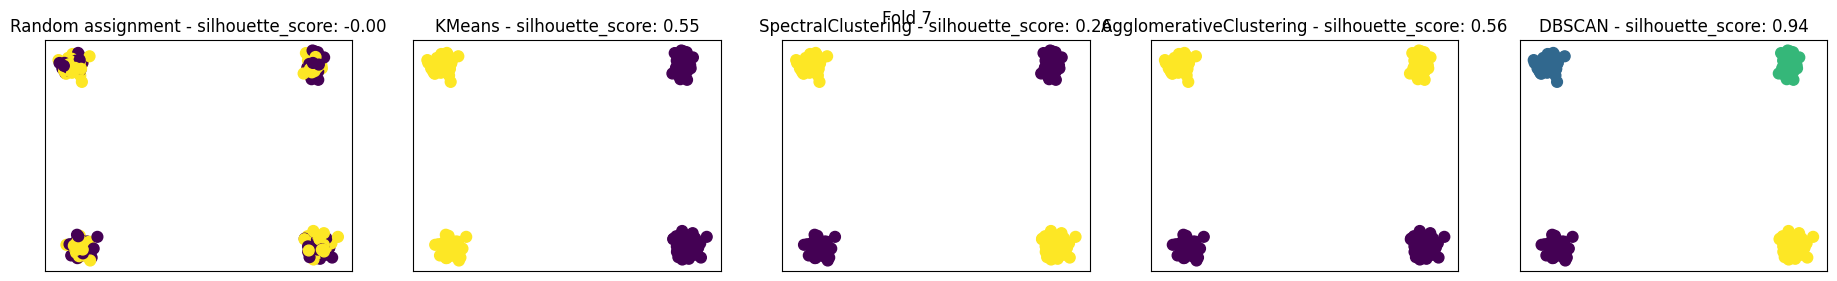

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


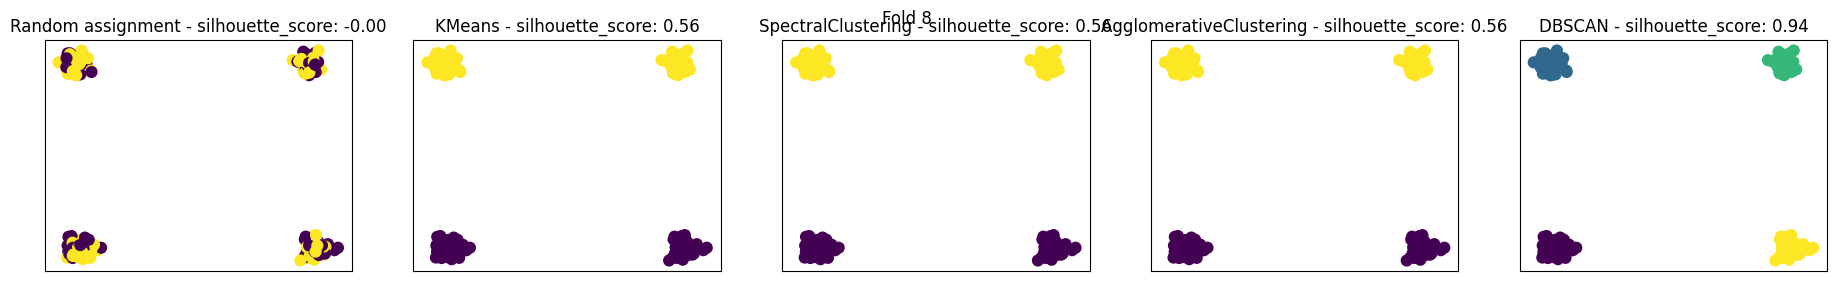

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


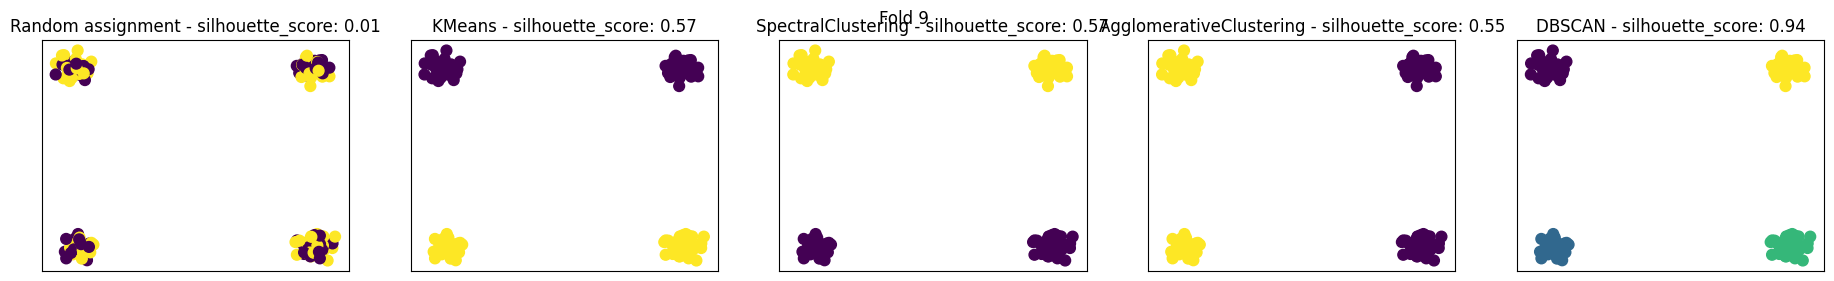

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


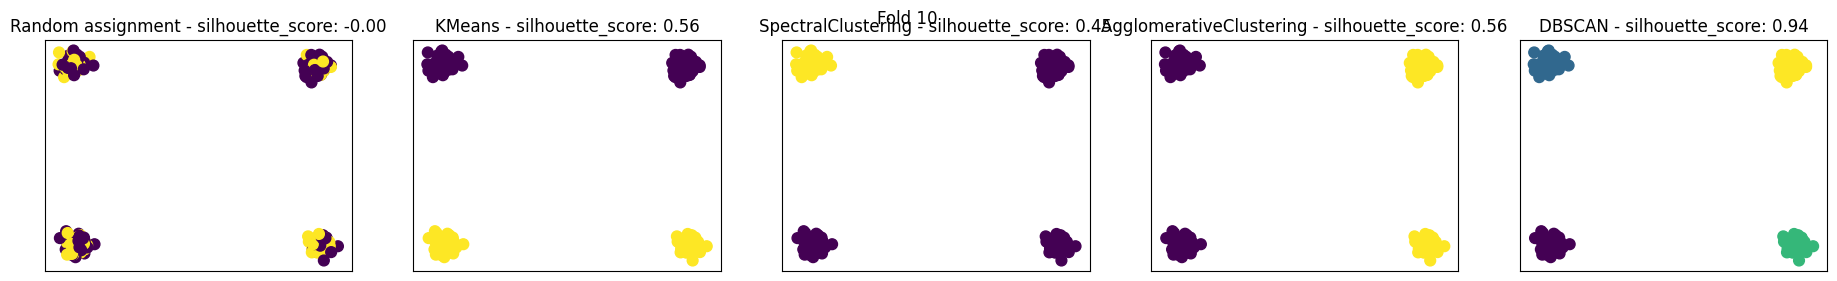

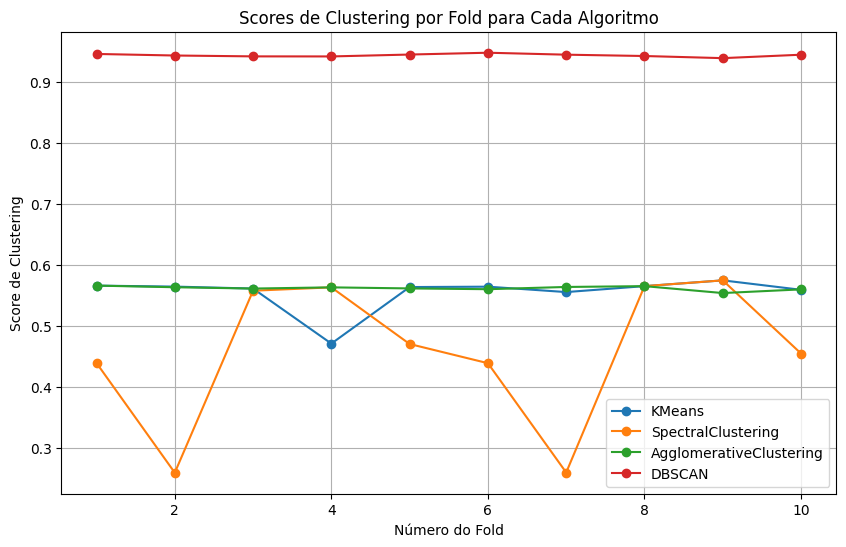

Médias das métricas após k-fold cross-validation: {'KMeans': 0.5540120231965691, 'SpectralClustering': 0.4577481060145289, 'AgglomerativeClustering': 0.5613178722049106, 'DBSCAN': 0.943178526868848}


In [75]:
num_classes = 2
feature_size = 2
X1, y1 = make_blobs(random_state=0,n_features=feature_size, centers=num_classes,n_samples=1000, cluster_std=0.15)
X2 = X1.copy()
a1 = np.where(X2[:,0] >1.5, X2[:,0]-1, X2[:,0])
a2 = np.where(X2[:,1] >3, X2[:,1]+1, X2[:,1])
X2 = np.array(np.concatenate((np.matrix(a1).T,np.matrix(a2).T),axis=1))
X1 = X2.copy()
X1[:,0] = X1[:,0]+5
y2 = (y1.copy()+1)%2
X3 = np.concatenate((X2,X1),axis=0)
y3 = np.concatenate((y1,y2),axis=0)

X = X3
y = y3

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical_kfold(X,y,cluster_metric=silhouette_score, unsupervised=True)


In [77]:
# Definindo as combinações de otimizadores e circuitos a serem testados
optimizers = {
    'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
    # 'RotosolveOptimizer': RotosolveOptimizer,
    'GradientDescentOptimizer': GradientDescentOptimizer,
    'SPSAOptimizer': qml.SPSAOptimizer
}

circuits = [(circuit_type1, 2), (circuit_type2, 4), (circuit_type3, 6), (circuit_type4, 6), (circuit_type5, 8)]

# Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
    'RotosolveOptimizer': {},
    'GradientDescentOptimizer': {'stepsize': 0.1},
    'SPSAOptimizer': {'maxiter': 10}
}

# Parâmetros do experimento
num_layers_options = [2, 4]  # Escolher o número de camadas para o experimento

# Armazenamento dos melhores resultados
best_results = {
    'optimizer': None,
    'circuit_type': None,
    'num_layers': None,
    'avg_score': float('inf'),
    'weights': None,
    'bias': None
}

# Loop para experimentar combinações
for circuit_fn, num_params_w_lines in circuits:
    for optimizer_name, optimizer_class in optimizers.items():
        for num_layers in num_layers_options:
            print(f"{circuit_fn} - {optimizer_name} - {num_layers}")
            # Instanciar o circuito e o QNode
            circuit = circuit_fn
            qnode = qml.QNode(circuit, dev, interface="torch")

            # # Inicializar o otimizador com seus parâmetros
            # optimizer = optimizer_class(**optimizer_params.get(optimizer_name, {}))

            # Treinamento com k-fold
            weights, bias, avg_score = train_kfold(
                qnode,
                X,
                y,
                num_qubits=2,
                num_params_w_lines=num_params_w_lines,
                num_params_w_columns=3,
                metric=metric_square_loss_silhouette,
                metricValidation=metric_square_loss_rand_score,
                num_layers=num_layers,
                weight_init_max=np.pi,
                optimizer=optimizer_class,
                dic_optimizer=optimizer_params[optimizer_name],
                seed=1,
                inputInLayer=False,
                iterations=10
            )

            # Armazenar os melhores resultados
            if avg_score < best_results['avg_score']:
                best_results.update({
                    'optimizer': optimizer_name,
                    'circuit_type': circuit_fn.__name__,
                    'num_layers': num_layers,
                    'avg_score': avg_score,
                    'weights': weights,
                    'bias': bias,
                    'qnode': qnode
                })

# Exibir os melhores parâmetros e resultados
print("Melhores Resultados:")
print(f"Otimizer: {best_results['optimizer']}")
print(f"Circuit Type: {best_results['circuit_type']}")
print(f"Num Layers: {best_results['num_layers']}")
print(f"Avg Score: {best_results['avg_score']}")

# Visualizar a decisão do melhor modelo
print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])


<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.4482
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4272
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.4482
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4272
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4458008 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     2 | Cost (metric_square_loss_silhouette): 0.4497070 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     3 | Cost (metric_square_loss_silhouette): 0.4438477 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4050
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4050
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Score médio de validação após 10-fold: 0.2983
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.3376
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Score médio de validação após 10-fold: 0.2983
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.3376
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.7734375 | Acc validation (metric_square_loss_rand_score): 0.1888428
Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.1133423
Iter:     3 | Cost (metric_square_loss_silhouette): 0.7675781 | Acc validation (metric_square_loss_rand_score): 0.0863647
Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.1646729
Iter:     5 | Cost (metric_square_loss_silhouette): 0.7729492 | Acc validation (metric_square_loss_rand_score): 0.1809082
Iter:     6 | Cost (metric_square_loss_silhouette): 0.7631836 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281
Score médio de validação após 10-fold: 0.4119
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188
Score médio de validação após 10-fold: 0.4521
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281
Score médio de validação após 10-fold: 0.4119
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188
Score médio de validação após 10-fold: 0.4521
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.5986328 | Acc validation (metric_square_loss_rand_score): 0.3962402
Iter:     2 | Cost (metric_square_loss_silhouette): 0.5537109 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     4 | Cost (metric_square_loss_silhouette): 0.5537109 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     5 | Cost (metric_square_loss_silhouette): 0.5976562 | Acc validation (metric_square_loss_rand_score): 0.4511719
Iter:     6 | Cost (metric_square_loss_silhouette): 0.5083008 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316
Score médio de validação após 10-fold: 0.3855
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316
Score médio de validação após 10-fold: 0.3855
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.5898438 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     2 | Cost (metric_square_loss_silhouette): 0.6640625 | Acc validation (metric_square_loss_rand_score): 0.3276367
Iter:     3 | Cost (metric_square_loss_silhouette): 0.7060547 | Acc validation (metric_square_loss_rand_score): 0.2836914
Iter:     4 | Cost (metric_square_loss_silhouette): 0.7080078 | Acc validation (metric_square_loss_rand_score): 0.2836914
Iter:     5 | Cost (metric_square_loss_silhouette): 0.7060547 | Acc validation (metric_square_loss_rand_score): 0.2902832
Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_

KeyboardInterrupt: 

In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi, 
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=50)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)